In [1]:
# magic command for automatic reload of python modules without needing to restart the notebook
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import math as m
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
import utils as utl
import scipy as sc
from collections import OrderedDict
# importing NN library
import torch as tr
import torch.nn as nn
# importing torch distributions and transformations 
import torch.distributions as trd
import torch.distributions.transforms as trt
from models import ConditionalModel, QuantileRegressionModel
from sklearn import preprocessing

In [3]:
#Reading expense data
df_trn = pd.read_csv('Predictive_Expenses_DATA/train.csv')
df_tst = pd.read_csv('Predictive_Expenses_DATA/test.csv')

# Reading macroeconomic indicators (inflation and unemployment rates)
df_macro=pd.read_csv('Predictive_Expenses_DATA/macroeconomic_indicators.csv')
df_macro=df_macro.drop(columns=['Unnamed: 0'])

# Merging tables
df_trn = df_trn.merge(df_macro,on=['year','month'])
df_tst = df_tst.merge(df_macro,on=['year','month'])

# Preprocess the data
df_trn, df_vld = utl.preProcess(df_trn)
df_tst = utl.preProcess(df_tst, split=False)

print(f'\033[1m Train Data Size: \033[0m {len(df_trn)}, \033[1m Validation Data Size: \033[0m {len(df_vld)}, \033[1m Test Data Size: \033[0m {len(df_tst)}')


# # Keeping only positive portion of the data
# df_trn = df_trn.loc[df_trn['expense']>1]

 Train Data Size:  538306,  Validation Data Size:  179436,  Test Data Size:  185469


In [4]:
# Specifying the target and covariates for regression
log_transform_expense=True
target = 'log_expense' if log_transform_expense else 'expense'
covariates=df_trn.columns.to_list()
to_remove=['id','wi','year', 'month','income','expense','log_expense']
covariates = [var for var in covariates if var not in to_remove]
print(f'\033[1m Covariates:\033[0m {covariates}')
print(f'\033[1m Target: \033[0m{target}')

 Covariates: ['age', 'education', 'familysize', 'urban', 'race', 'region', 'state', 'marital', 'occupation', 'unemployment', 'inflation', 'unemployment_lagging', 'inflation_lagging', 'log_income']
 Target: log_expense


 Covariates: ['age', 'education', 'familysize', 'marital', 'occupation', 'log_income']


C:\Users\tewar\Anaconda3\envs\pythonEnvPyTorch\lib\site-packages\ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


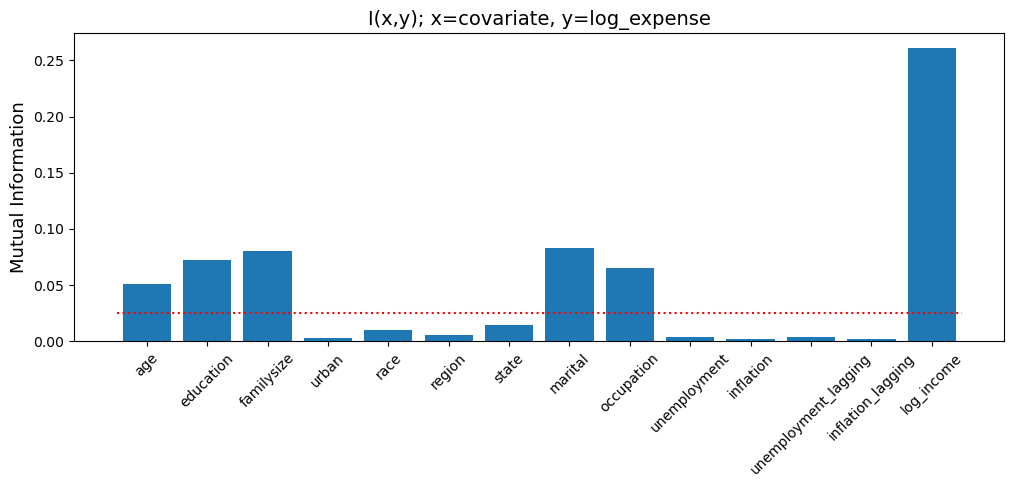

In [5]:
# Assessing Information Content (about the target) of the covariates via Mutual infromation (MI)
mutual_info={}
y = utl.discretize(df_trn[target],20) # target variable (discretizing it for MI calculation)
for var in covariates:
    x=df_trn[var].to_numpy()
    x=utl.discretize(x,20)
    mutual_info[var]=mutual_info_score(x,y)
    
MI_threshold=0.025 if log_transform_expense else 0.0005 # Thrshold for mutual Information
# plotting MI
plt.figure(figsize=(12,4))
plt.bar(list(mutual_info.keys()), list(mutual_info.values()));
plt.plot(np.arange(-1,len(covariates))+0.5,np.array([MI_threshold]*(len(covariates)+1)),'r:')
ax=plt.gca();
ax.set_xticklabels(list(mutual_info.keys()), rotation = 45);
plt.ylabel('Mutual Information',fontsize=13)
plt.title('I(x,y); x=covariate, y=log_expense',fontsize=14)

# Keeping only those covariate with MI above the specified threshold
covariates=[var for var in covariates if mutual_info[var]>MI_threshold]
print(f'\033[1m Covariates:\033[0m {covariates}')


In [6]:
# Defining the Covariate Type (Categorical, Numeric). Ordinal Variable (eduction) is considered Numeric here.
covariates_categorical = ['marital','occupation']
covariates_numeric = [var for var in covariates if var not in covariates_categorical] # + ['unemployment','inflation']
print(f'\033[1m Categorical Covariates: \033[0m {covariates_categorical}')
print(f'\033[1m Numerical Covariates: \033[0m {covariates_numeric}')

 Categorical Covariates:  ['marital', 'occupation']
 Numerical Covariates:  ['age', 'education', 'familysize', 'log_income']


In [7]:
# Standardizing Numerical covariates
standard_transforms={}
for var in covariates_numeric+[target]:
    # estimate loc and scale w.r.t to training dataset
    standardize = preprocessing.StandardScaler().fit(df_trn[var].to_numpy().reshape(-1,1))
    df_trn[var]=standardize.transform(df_trn[var].to_numpy().reshape(-1,1))
    # also standardize the validation and test datasets
    df_vld[var]=standardize.transform(df_vld[var].to_numpy().reshape(-1,1))
    if var in df_tst:
        df_tst[var]=standardize.transform(df_tst[var].to_numpy().reshape(-1,1))
    standard_transforms[var]=standardize

In [8]:
# Hot encoding the categorical variables for all datasets 
df_trn_categorical, new_covariates_categorical=utl.hotEncodeData(df_trn,covariates_categorical)
df_vld_categorical,_=utl.hotEncodeData(df_vld,covariates_categorical)
df_tst_categorical,_=utl.hotEncodeData(df_tst,covariates_categorical)

# Joing the categorical tables into the original tables
df_trn = pd.concat([df_trn,df_trn_categorical],ignore_index=False,axis=1)
df_vld = pd.concat([df_vld,df_vld_categorical],ignore_index=False,axis=1)
df_tst = pd.concat([df_tst,df_tst_categorical],ignore_index=False,axis=1)
# freeing up memory
del df_trn_categorical, df_vld_categorical, df_tst_categorical

In [9]:
# collecting all covariate names
covariates=new_covariates_categorical+covariates_numeric

# Training Model

In [10]:
# Defining train step
def train_step(row_ids,q):
    exp_model.train()
    X_batch, y_batch, w_batch = utl.getBatch(df_trn, 
                                    row_ids, 
                                    covariates,
                                    target)            
    X_batch, y_batch, w_batch = map(tr.FloatTensor,(X_batch,y_batch, w_batch))
    Q_batch=exp_model.forward(X_batch)
    return utl.pinballLoss(Q_batch, q, y_batch, w_batch)
    
# Defining validation step
def valid_step(row_ids, q):
    exp_model.eval()
    X_batch, y_batch, w_batch = utl.getBatch(df_vld, 
                                    row_ids, 
                                    covariates,
                                    target)       
    X_batch, y_batch, w_batch = map(tr.FloatTensor,(X_batch,y_batch, w_batch))
    with tr.no_grad(): 
        Q_batch=exp_model.forward(X_batch)
    return utl.pinballLoss(Q_batch, q, y_batch, w_batch)    

# Defining t
def fit(quantiles_at, epochs=10, batch_size_train=100, batch_size_valid=500, lr=1E-3, print_every=100):
    n_train = len(df_trn)
    n_valid = len(df_vld)
    n_iters = n_train//batch_size_train+1
    loss_train,loss_valid=[],[]
          
    for epoch in range(epochs):           
        # reshuffling trainig data at every epoch
        trn_indices=df_trn.index.to_list()
        np.random.shuffle(trn_indices)
        # Training 
        for itr in range(n_iters):
            st,en=itr*batch_size_train, min(n_train,(itr+1)*batch_size_train)
            row_ids =  trn_indices[st:en]          
            trn_loss = train_step(row_ids,quantiles_at)          
            trn_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            if itr%print_every==0:
                # Validation Step
                vld_indices=df_vld.index.to_list()
                row_ids = np.random.choice(vld_indices,batch_size_valid,replace=False).tolist()
                vld_loss = valid_step(row_ids, quantiles_at)
                # rounding losses              
                trn_loss=np.round(float(trn_loss.data),2)
                vld_loss=np.round(float(vld_loss.data),2)
                
                
                print(f'Epoch: {epoch}, Iter: {itr}, Train Loss: {trn_loss}, Valid Loss: {vld_loss}')
                loss_train.append(trn_loss)
                loss_valid.append(vld_loss)
    return loss_train, loss_valid
    
        

In [11]:
# Instantiating the DNN based conditional density model for the target i.e. p(y|X)
input_dim = len(covariates)
print(f'Input Dimensions: {input_dim}')
quantiles_at = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
layers = [input_dim, input_dim, input_dim]
exp_model=QuantileRegressionModel(input_dim,layers,quantiles_at)
optimizer = tr.optim.Adam(exp_model.parameters(),lr=1E-4)

# fitting the model
loss_train, loss_valid=fit(quantiles_at, 
                           batch_size_train=200, 
                           batch_size_valid=1000, 
                           epochs=10)

Input Dimensions: 26
Epoch: 0, Iter: 0, Train Loss: 827.86, Valid Loss: 699.37
Epoch: 0, Iter: 100, Train Loss: 650.62, Valid Loss: 621.4
Epoch: 0, Iter: 200, Train Loss: 588.94, Valid Loss: 563.44
Epoch: 0, Iter: 300, Train Loss: 501.46, Valid Loss: 462.35
Epoch: 0, Iter: 400, Train Loss: 420.85, Valid Loss: 428.0
Epoch: 0, Iter: 500, Train Loss: 434.53, Valid Loss: 376.53
Epoch: 0, Iter: 600, Train Loss: 350.03, Valid Loss: 360.16
Epoch: 0, Iter: 700, Train Loss: 382.28, Valid Loss: 310.72
Epoch: 0, Iter: 800, Train Loss: 351.94, Valid Loss: 322.66
Epoch: 0, Iter: 900, Train Loss: 298.45, Valid Loss: 307.57
Epoch: 0, Iter: 1000, Train Loss: 316.1, Valid Loss: 281.2
Epoch: 0, Iter: 1100, Train Loss: 255.47, Valid Loss: 278.07
Epoch: 0, Iter: 1200, Train Loss: 249.4, Valid Loss: 244.84
Epoch: 0, Iter: 1300, Train Loss: 266.46, Valid Loss: 260.1
Epoch: 0, Iter: 1400, Train Loss: 242.46, Valid Loss: 260.45
Epoch: 0, Iter: 1500, Train Loss: 266.7, Valid Loss: 251.19
Epoch: 0, Iter: 1600, 

Epoch: 5, Iter: 100, Train Loss: 228.62, Valid Loss: 236.39
Epoch: 5, Iter: 200, Train Loss: 243.34, Valid Loss: 235.49
Epoch: 5, Iter: 300, Train Loss: 260.65, Valid Loss: 223.16
Epoch: 5, Iter: 400, Train Loss: 251.57, Valid Loss: 237.33
Epoch: 5, Iter: 500, Train Loss: 248.04, Valid Loss: 217.51
Epoch: 5, Iter: 600, Train Loss: 246.21, Valid Loss: 225.74
Epoch: 5, Iter: 700, Train Loss: 257.48, Valid Loss: 229.52
Epoch: 5, Iter: 800, Train Loss: 204.54, Valid Loss: 234.63
Epoch: 5, Iter: 900, Train Loss: 254.63, Valid Loss: 218.72
Epoch: 5, Iter: 1000, Train Loss: 215.09, Valid Loss: 245.67
Epoch: 5, Iter: 1100, Train Loss: 218.98, Valid Loss: 225.8
Epoch: 5, Iter: 1200, Train Loss: 197.39, Valid Loss: 209.9
Epoch: 5, Iter: 1300, Train Loss: 241.33, Valid Loss: 245.9
Epoch: 5, Iter: 1400, Train Loss: 199.74, Valid Loss: 227.67
Epoch: 5, Iter: 1500, Train Loss: 223.98, Valid Loss: 232.3
Epoch: 5, Iter: 1600, Train Loss: 298.18, Valid Loss: 228.58
Epoch: 5, Iter: 1700, Train Loss: 214

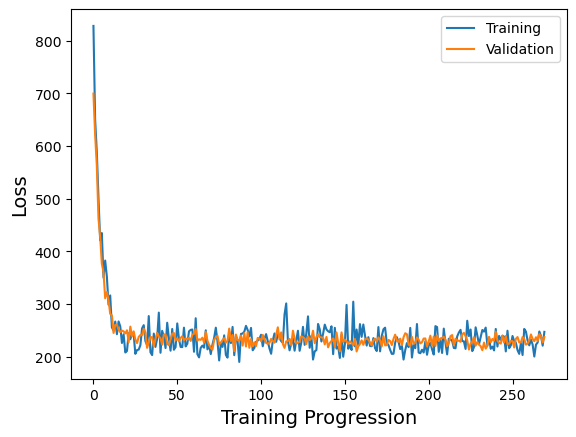

In [12]:
# Plotting Losses
plt.plot(loss_train)
plt.plot(loss_valid)
plt.xlabel('Training Progression',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.legend(['Training','Validation'])

In [18]:
# Saving model
filename='QuantileRegressionModel_Macro_Log_Expense'
tr.save(exp_model.state_dict(), 'saved_models/'+filename)

# Evaluating Model Performance

In [16]:
# Finally setting up the expense quantile calculation
# Define the transformation of the target from the model-space to the actual-space
target_transform=trt.AffineTransform(standard_transforms[target].mean_[0],
                                              standard_transforms[target].scale_[0])
# If log-transformation was used on expense data, augument it to the target transform
if log_transform_expense:
    exp_transform=trt.ExpTransform()
    target_transform=trt.ComposeTransform([target_transform,exp_transform]) 


# Evaluating the model on the entire validation dataset 
row_ids = df_vld.index.to_list()
X_valid,y_valid, w_valid = utl.getBatch(df_vld, 
                       row_ids,
                       covariates,
                       target)
X_valid,y_valid, w_valid  = map(tr.FloatTensor,(X_valid,y_valid, w_valid)) 
with tr.no_grad():
    quantiles=exp_model.forward(X_valid)
# Transforming the quantiles and the observed data back to the original space
quantiles=target_transform(quantiles).numpy()
y_valid=target_transform(y_valid)
quantiles_95_PI=quantiles[:,[1,4,7]]
q = [quantiles_at[i] for i in [1,4,7]]

 PinBall Loss:  629545.3125


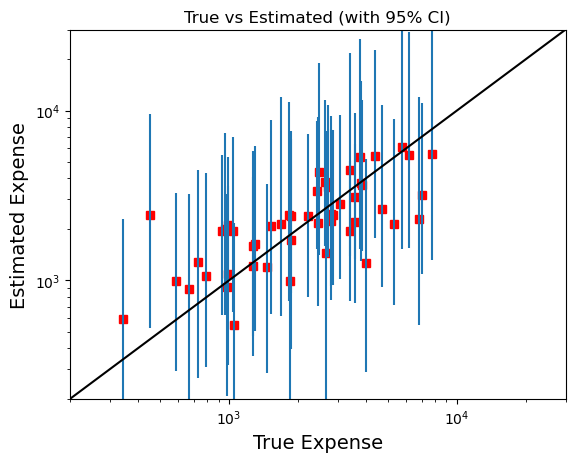

In [17]:
# Plotting a few random samples of true Expense vs. the estimated with 90% CI
np.random.seed(3)
ax_limits=[200,30000]
utl.plotQuantiles(y_valid,quantiles_95_PI,50, axis_labels={'x':'True Expense', 'y':'Estimated Expense'})
plt.plot(np.array(ax_limits),np.array(ax_limits),'k-')
plt.xlim(ax_limits)
plt.ylim(ax_limits)
print(f'\033[1m PinBall Loss: \033[0m {utl.pinballLoss(quantiles_95_PI, q, y_valid, w_valid)}')